In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn

In [2]:
print(sklearn.__version__)

0.24.1


In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [4]:
data = pd.read_csv('stoch_corr_tanh_rho_1000.csv', header=None)

C:\Users\danci\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [55]:
observations = data.iloc[:100000, 1:1000]
paramsets = data.iloc[:100000, 1003:1004]

In [56]:
params_reshape = np.array(paramsets).reshape(100000, 1, 1)
one_sample_reshape = np.array(np.diff(observations)).reshape(100000,1,998)

In [57]:
print(params_reshape.shape, one_sample_reshape.shape)

(100000, 1, 1) (100000, 1, 998)


In [64]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential()
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True, input_shape=(1, 998)))
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16))
model.add(layer=tf.keras.layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             64960     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 69,201
Trainable params: 69,201
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.mse,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)

history = model.fit(x=one_sample_reshape, y=params_reshape, epochs=100, validation_split=0.2, batch_size=64, verbose=1)

Epoch 1/100
1250/1250 [==============================] - 17s 11ms/step - loss: 2.2554e-05 - val_loss: 1.3219e-04
Epoch 2/100
1250/1250 [==============================] - 12s 9ms/step - loss: 2.2294e-05 - val_loss: 1.3467e-04
Epoch 3/100
1250/1250 [==============================] - 12s 9ms/step - loss: 2.2220e-05 - val_loss: 1.3183e-04
Epoch 4/100
1250/1250 [==============================] - 11s 9ms/step - loss: 2.2226e-05 - val_loss: 1.3129e-04
Epoch 5/100
1250/1250 [==============================] - 12s 9ms/step - loss: 2.2363e-05 - val_loss: 1.3175e-04
Epoch 6/100
1250/1250 [==============================] - 11s 9ms/step - loss: 2.2338e-05 - val_loss: 1.3351e-04
Epoch 7/100
1250/1250 [==============================] - 11s 8ms/step - loss: 2.1949e-05 - val_loss: 1.3316e-04
Epoch 8/100
1250/1250 [==============================] - 11s 8ms/step - loss: 2.2055e-05 - val_loss: 1.3422e-04
Epoch 9/100
1250/1250 [==============================] - 11s 9ms/step - loss: 2.2241e-05 - val_loss: 1.

In [87]:
simulated = []
predicted = []

append_index = 0
start = 90000

for i in tqdm(range(start, start + 200, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 998)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 0.005:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0]) 
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    # print(test_output, params_reshape[i])

100%|██████████| 200/200 [00:08<00:00, 23.84it/s]


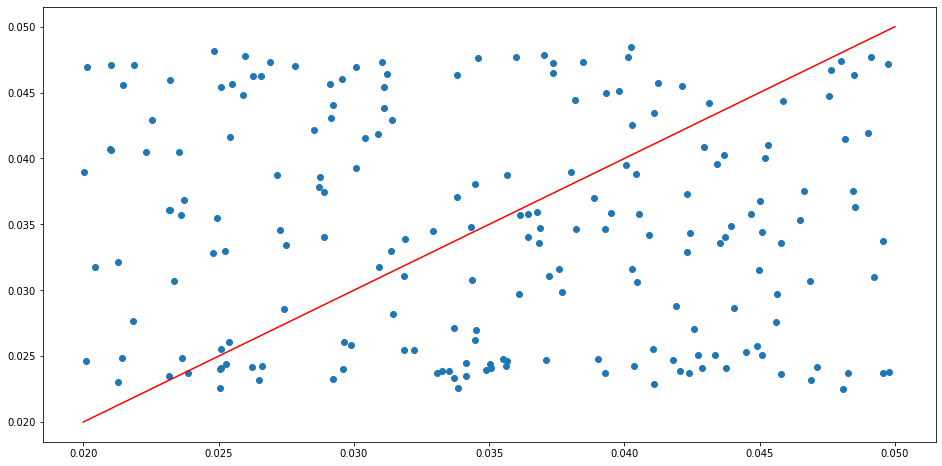

In [88]:
plt.figure(figsize=(16,8))
plt.plot([0.02,0.05], [0.02,0.05], 'red')
plt.scatter(simulated, predicted)
plt.show()

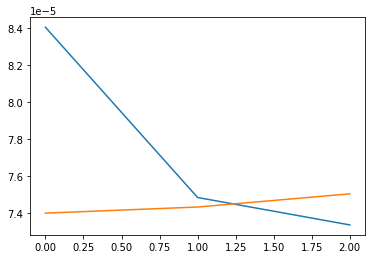

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()